<a href="https://colab.research.google.com/github/princeyyadav/cellular_aging/blob/master/TN_computation_and_age_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mount drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# install libraries

In [2]:
!pip install velocyto matplotlib seaborn matplotlib-venn scikit-learn

     |████████████████████████████████| 204kB 5.3MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 10.0MB 10.9MB/s 
     |████████████████████████████████| 51kB 6.1MB/s 
  Created wheel for velocyto: filename=velocyto-0.17.17-cp36-cp36m-linux_x86_64.whl size=363570 sha256=754c0e1313c44e48696977db463ebb3478eef2c041addfd2654ada78839b81a6
  Stored in directory: /root/.cache/pip/wheels/e0/10/47/5a2aa6a7179b17b50a19cdba1df71798ade77e7d9ce98c5300
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=b3d02b87dd115564c75c24ba468d729570f4e065a94d5474df29865d18562ba9
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28042 sha256=22c61ce2e578b243d1eee593ff18ef65d04b48af05c02c442019e015188b71fa
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f953

# import library

In [3]:
import time
import scipy
import pickle
import numpy as np
import pandas as pd
import velocyto as vcy

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_venn as ven
from matplotlib.gridspec import GridSpec

import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, cohen_kappa_score, confusion_matrix, recall_score, classification_report, precision_score
from scipy.stats import spearmanr, zscore
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.svm import SVR, SVC

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# path variables

In [4]:
# path variables
path = {}
root = "/content/drive/My Drive/cellular-aging-code/"
currentdir = root+"TN/"

path["loom"] = root + "data/pancreas.hdf5"
path["metadata"] = root + "data/metadata.csv"

# plots save location
path['save'] = root+"TN/"

# load loom file

In [5]:
%%time
# load data
vlm = vcy.load_velocyto_hdf5(path["loom"])
vlm.ca["CellID"] = np.asarray(vlm.ca["CellID"])

CPU times: user 8.61 s, sys: 1.15 s, total: 9.76 s
Wall time: 10.8 s


In [16]:
meta = pd.read_csv(path["metadata"], index_col=1).iloc[:,4:]
meta

,gender,inferred_cell_type,run,decade
geo_accession,,,,
GSM2171880,male,alpha,SRR3562210,3
GSM2171881,male,alpha,SRR3562211,3
GSM2171882,male,acinar,SRR3562212,3
GSM2171883,male,alpha,SRR3562213,3
GSM2171884,male,alpha,SRR3562214,3
...,...,...,...,...
GSM2174421,male,unsure,SRR3564749,3
GSM2174422,male,beta,SRR3564750,3
GSM2174423,male,mesenchymal,SRR3564751,3


# Get ercc spikeins count matrix

## list raw count files

In [10]:
# list dir
import os
path["tn_countfiles"] = root+"TN/rawfiles/"
files = pd.DataFrame(sorted(os.listdir(path["tn_countfiles"]))[:-3], columns=["actual_name"])
print(files, files.shape)
print(type(files))
files

                        actual_name
0     GSM2171880_1000010011.A07.csv
1     GSM2171881_1000010011.D12.csv
2     GSM2171882_1000010012.H10.csv
3     GSM2171883_1000010011.B07.csv
4     GSM2171884_1000010011.C01.csv
...                             ...
2539   GSM2174421_1000102801.H5.csv
2540   GSM2174422_1000102802.H3.csv
2541  GSM2174423_1000102803.F10.csv
2542   GSM2174424_1000102804.B8.csv
2543  GSM2174425_1000102801.B10.csv

[2544 rows x 1 columns] (2544, 1)
<class 'pandas.core.frame.DataFrame'>


,actual_name
0,GSM2171880_1000010011.A07.csv
1,GSM2171881_1000010011.D12.csv
2,GSM2171882_1000010012.H10.csv
3,GSM2171883_1000010011.B07.csv
4,GSM2171884_1000010011.C01.csv
...,...
2539,GSM2174421_1000102801.H5.csv
2540,GSM2174422_1000102802.H3.csv
2541,GSM2174423_1000102803.F10.csv
2542,GSM2174424_1000102804.B8.csv


## get geo_accession from filename

In [ ]:
temp = files["actual_name"].str.split("_", expand=True)[0]
files["geo_accession"] = temp
# print(temp.shape, type(temp[0]), temp[0], temp[0][0])
temp

0       GSM2171880
1       GSM2171881
2       GSM2171882
3       GSM2171883
4       GSM2171884
           ...    
2539    GSM2174421
2540    GSM2174422
2541    GSM2174423
2542    GSM2174424
2543    GSM2174425
Name: 0, Length: 2544, dtype: object

In [ ]:
vlm.ca["geo_accession"]

array(['GSM2171880', 'GSM2171881', 'GSM2171882', ..., 'GSM2174423',
       'GSM2174424', 'GSM2174425'], dtype=object)

In [ ]:
files.index = files["geo_accession"]
files = files.loc[vlm.ca["geo_accession"]]
print(files.shape)
files

(2481, 2)


,actual_name,geo_accession
geo_accession,,
GSM2171880,GSM2171880_1000010011.A07.csv,GSM2171880
GSM2171881,GSM2171881_1000010011.D12.csv,GSM2171881
GSM2171882,GSM2171882_1000010012.H10.csv,GSM2171882
GSM2171883,GSM2171883_1000010011.B07.csv,GSM2171883
GSM2171884,GSM2171884_1000010011.C01.csv,GSM2171884
...,...,...
GSM2174421,GSM2174421_1000102801.H5.csv,GSM2174421
GSM2174422,GSM2174422_1000102802.H3.csv,GSM2174422
GSM2174423,GSM2174423_1000102803.F10.csv,GSM2174423


## get ercc spikein names  
100 spikeins found in every cell


In [ ]:
for i,fname in enumerate(files["actual_name"][:1]):
  fpath = path["tn_countfiles"]+fname
  dfi = pd.read_csv(fpath, index_col=0, sep="\t", header=None)
  temp = dfi.index.str.slice(start=0,stop=4)=="ERCC"
  print(temp, temp.sum())
  spikeins = dfi.index[temp]
  print(spikeins.shape, spikeins, type(spikeins.values))

#### now i have ercc spikeins names and samples names of cells
#### i can create the new dataframe, where i will store the count of errc spikeins for each cell sample

[False False False ... False False False] 100
(100,) Index(['ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009', 'ERCC-00012',
       'ERCC-00013', 'ERCC-00014', 'ERCC-00016', 'ERCC-00017', 'ERCC-00019',
       'ERCC-00022', 'ERCC-00024', 'ERCC-00025', 'ERCC-00028', 'ERCC-00031',
       'ERCC-00033', 'ERCC-00034', 'ERCC-00035', 'ERCC-00039', 'ERCC-00040',
       'ERCC-00041', 'ERCC-00042', 'ERCC-00043', 'ERCC-00044', 'ERCC-00046',
       'ERCC-00048', 'ERCC-00051', 'ERCC-00053', 'ERCC-00054', 'ERCC-00057',
       'ERCC-00058', 'ERCC-00059', 'ERCC-00060', 'ERCC-00061', 'ERCC-00062',
       'ERCC-00067', 'ERCC-00069', 'ERCC-00071', 'ERCC-00073', 'ERCC-00074',
       'ERCC-00075', 'ERCC-00076', 'ERCC-00077', 'ERCC-00078', 'ERCC-00079',
       'ERCC-00081', 'ERCC-00083', 'ERCC-00084', 'ERCC-00085', 'ERCC-00086',
       'ERCC-00092', 'ERCC-00095', 'ERCC-00096', 'ERCC-00097', 'ERCC-00098',
       'ERCC-00099', 'ERCC-00104', 'ERCC-00108', 'ERCC-00109', 'ERCC-00111',
       'ERCC-00112', 'E

,ERCC-00002,ERCC-00003,ERCC-00004,ERCC-00009,ERCC-00012,ERCC-00013,ERCC-00014,ERCC-00016,ERCC-00017,ERCC-00019,ERCC-00022,ERCC-00024,ERCC-00025,ERCC-00028,ERCC-00031,ERCC-00033,ERCC-00034,ERCC-00035,ERCC-00039,ERCC-00040,ERCC-00041,ERCC-00042,ERCC-00043,ERCC-00044,ERCC-00046,ERCC-00048,ERCC-00051,ERCC-00053,ERCC-00054,ERCC-00057,ERCC-00058,ERCC-00059,ERCC-00060,ERCC-00061,ERCC-00062,ERCC-00067,ERCC-00069,ERCC-00071,ERCC-00073,ERCC-00074,...,ERCC-00112,ERCC-00113,ERCC-00116,ERCC-00117,ERCC-00120,ERCC-00123,ERCC-00126,ERCC-00130,ERCC-00131,ERCC-00134,ERCC-00136,ERCC-00137,ERCC-00138,ERCC-00142,ERCC-00143,ERCC-00144,ERCC-00145,ERCC-00147,ERCC-00148,ERCC-00150,ERCC-00154,ERCC-00156,ERCC-00157,ERCC-00158,ERCC-00160,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171,ERCC1,ERCC2,ERCC3,ERCC4,ERCC5,ERCC6,ERCC6L,ERCC8
geo_accession,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GSM2171880,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GSM2171881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GSM2171882,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GSM2171883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GSM2171884,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2174421,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GSM2174422,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GSM2174423,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
np.sort(spikeins)

array(['ERCC-00002', 'ERCC-00003', 'ERCC-00004', 'ERCC-00009',
       'ERCC-00012', 'ERCC-00013', 'ERCC-00014', 'ERCC-00016',
       'ERCC-00017', 'ERCC-00019', 'ERCC-00022', 'ERCC-00024',
       'ERCC-00025', 'ERCC-00028', 'ERCC-00031', 'ERCC-00033',
       'ERCC-00034', 'ERCC-00035', 'ERCC-00039', 'ERCC-00040',
       'ERCC-00041', 'ERCC-00042', 'ERCC-00043', 'ERCC-00044',
       'ERCC-00046', 'ERCC-00048', 'ERCC-00051', 'ERCC-00053',
       'ERCC-00054', 'ERCC-00057', 'ERCC-00058', 'ERCC-00059',
       'ERCC-00060', 'ERCC-00061', 'ERCC-00062', 'ERCC-00067',
       'ERCC-00069', 'ERCC-00071', 'ERCC-00073', 'ERCC-00074',
       'ERCC-00075', 'ERCC-00076', 'ERCC-00077', 'ERCC-00078',
       'ERCC-00079', 'ERCC-00081', 'ERCC-00083', 'ERCC-00084',
       'ERCC-00085', 'ERCC-00086', 'ERCC-00092', 'ERCC-00095',
       'ERCC-00096', 'ERCC-00097', 'ERCC-00098', 'ERCC-00099',
       'ERCC-00104', 'ERCC-00108', 'ERCC-00109', 'ERCC-00111',
       'ERCC-00112', 'ERCC-00113', 'ERCC-00116', 'ERCC-

## append spikein counts for each cell to new df

In [ ]:
%%time
# now fill in counts
  # i have spikeins, access these using loc

# new dataframe
df = pd.DataFrame(columns=spikeins)

for i,fname in enumerate(files["actual_name"]):

  fpath = path["tn_countfiles"]+fname
  geo_acc = files["geo_accession"][i]
  dfi = pd.read_csv(fpath, index_col=0, sep="\t", header=None).loc[spikeins]
  dfi.columns = [geo_acc]
  dfi = dfi.transpose()
  # append it with new df
  df = df.append(dfi, ignore_index=False)

df

Streaming output truncated to the last 5000 lines.
0           ERCC-00002  ERCC-00003  ERCC-00004  ...  ERCC6  ERCC6L  ERCC8
GSM2173372        9550         555        2359  ...     33       0      0

[1 rows x 100 columns]
(1, 100)
0           ERCC-00002  ERCC-00003  ERCC-00004  ...  ERCC6  ERCC6L  ERCC8
GSM2173373       15016         526        2583  ...      0       0      0

[1 rows x 100 columns]
(1, 100)
0           ERCC-00002  ERCC-00003  ERCC-00004  ...  ERCC6  ERCC6L  ERCC8
GSM2173374       14930         947        3039  ...      0       0      0

[1 rows x 100 columns]
(1, 100)
0           ERCC-00002  ERCC-00003  ERCC-00004  ...  ERCC6  ERCC6L  ERCC8
GSM2173375        7136         357        1858  ...      0       0      0

[1 rows x 100 columns]
(1, 100)
0           ERCC-00002  ERCC-00003  ERCC-00004  ...  ERCC6  ERCC6L  ERCC8
GSM2173376        2270         151         384  ...      0       0      0

[1 rows x 100 columns]
(1, 100)
0           ERCC-00002  ERCC-00003  ERCC-000

,ERCC-00002,ERCC-00003,ERCC-00004,ERCC-00009,ERCC-00012,ERCC-00013,ERCC-00014,ERCC-00016,ERCC-00017,ERCC-00019,ERCC-00022,ERCC-00024,ERCC-00025,ERCC-00028,ERCC-00031,ERCC-00033,ERCC-00034,ERCC-00035,ERCC-00039,ERCC-00040,ERCC-00041,ERCC-00042,ERCC-00043,ERCC-00044,ERCC-00046,ERCC-00048,ERCC-00051,ERCC-00053,ERCC-00054,ERCC-00057,ERCC-00058,ERCC-00059,ERCC-00060,ERCC-00061,ERCC-00062,ERCC-00067,ERCC-00069,ERCC-00071,ERCC-00073,ERCC-00074,...,ERCC-00112,ERCC-00113,ERCC-00116,ERCC-00117,ERCC-00120,ERCC-00123,ERCC-00126,ERCC-00130,ERCC-00131,ERCC-00134,ERCC-00136,ERCC-00137,ERCC-00138,ERCC-00142,ERCC-00143,ERCC-00144,ERCC-00145,ERCC-00147,ERCC-00148,ERCC-00150,ERCC-00154,ERCC-00156,ERCC-00157,ERCC-00158,ERCC-00160,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171,ERCC1,ERCC2,ERCC3,ERCC4,ERCC5,ERCC6,ERCC6L,ERCC8
GSM2171880,821,124,437,471,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,282,391,0,604,0,0,0,0,0,0,0,24,0,0,0,0,0,0,1929,...,300,446,0,0,0,0,0,2283,58,0,946,0,0,0,0,0,130,0,0,0,0,0,0,0,0,20,0,0,0,0,0,168,11,0,2,0,11,0,0,0
GSM2171881,569,374,532,194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,474,105,0,533,0,1,0,0,0,0,0,3,0,0,0,0,0,0,1605,...,0,350,0,0,0,0,0,1917,0,0,465,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,0,0,0,1,0,0,0,0
GSM2171882,272,22,56,30,0,0,0,0,0,0,2,0,39,0,0,0,0,0,0,0,0,0,67,9,79,0,1,0,0,0,0,0,13,0,0,0,0,0,0,379,...,0,178,54,0,0,0,0,843,0,0,234,0,0,0,0,0,112,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,3,0,0,0,1,0,0,0
GSM2171883,581,10,359,180,0,0,0,0,0,0,40,0,1,0,0,0,0,0,0,0,0,400,150,0,286,0,0,0,0,0,0,0,14,0,0,0,0,0,0,1152,...,0,224,0,0,0,0,0,1676,0,0,465,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,0,0,0,0,0,1,0,0
GSM2171884,138,61,123,14,0,0,0,0,0,0,54,0,133,0,0,0,0,0,0,0,0,0,74,0,158,0,0,0,0,0,0,0,1,0,0,0,0,0,0,333,...,2,191,52,0,0,0,0,622,0,0,1,0,0,0,0,0,44,0,0,0,0,0,0,0,0,0,0,0,0,0,52,40,0,13,0,56,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2174421,27051,3057,6460,1106,0,0,0,0,0,209,1091,0,13,0,0,0,0,0,0,0,0,2614,1193,178,6057,0,1,0,0,0,0,0,434,0,418,0,0,95,0,14803,...,39,8196,0,0,0,0,0,29606,462,0,3347,0,0,0,0,0,172,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3401,0,0,0,0,0,0,0,1
GSM2174422,9449,512,2328,1095,0,0,0,0,0,0,200,0,0,0,0,0,1,35,0,0,0,648,115,2,2530,0,0,0,3,0,0,0,256,0,0,120,0,0,0,8004,...,206,2163,0,0,0,0,0,11404,65,0,1853,0,0,0,0,182,468,0,0,0,0,0,0,0,0,86,0,0,3,0,0,1761,0,0,0,39,0,0,0,0
GSM2174423,3859,548,819,495,0,0,0,0,0,27,35,0,49,0,0,0,0,0,0,0,0,242,238,79,775,0,0,0,0,0,0,0,33,0,23,0,0,0,0,3185,...,0,1253,461,0,2,0,0,3831,0,0,672,0,0,0,0,31,48,0,11,0,0,0,69,0,0,1,0,0,0,0,0,445,0,0,2,0,15,0,0,0
GSM2174424,6412,730,1436,110,0,0,0,0,0,0,30,0,0,0,0,0,0,33,0,0,0,78,594,0,1328,0,0,0,1,0,0,24,86,0,123,0,0,53,0,4946,...,169,2068,312,0,0,0,188,8244,69,0,1083,0,0,0,0,34,16,0,43,0,29,0,0,0,0,0,65,0,139,0,26,824,0,0,0,0,0,0,0,0


In [ ]:
# checking if cloumns of ith cell and final df same or not
print((dfi.columns == df.columns).sum(), df.shape)

100 (2481, 100)


In [ ]:
vlm.S.shape

(57905, 2481)

In [ ]:
print(df.shape)

df
currentdir

(2481, 100)


'/content/drive/My Drive/Thesis/newPipe/TN/'


# save files

In [ ]:
# save ercc spikeins
df.to_csv(currentdir+"spikein_counts.csv")

In [ ]:
# save raw counts of spliced, unspliced
s = pd.DataFrame(vlm.S, columns=vlm.ca["geo_accession"], index=vlm.ra["Gene"])
s = s.transpose()
s = s.loc[:,vel.columns]
print(s.shape)
s.to_csv(currentdir+"S_raw_count.csv")

# unspliced
u = pd.DataFrame(vlm.U, columns=vlm.ca["geo_accession"], index=vlm.ra["Gene"])
u = u.transpose()
u = u.loc[:,vel.columns]
print(u.shape)
u.to_csv(currentdir+"U_raw_count.csv")

# total
T = vlm.S+vlm.U
print(T.shape)
su = pd.DataFrame(T, columns=vlm.ca["geo_accession"], index=vlm.ra["Gene"])
su = su.transpose()
su = su.loc[:,vel.columns]
print(su.shape)
su.to_csv(currentdir+"SU_raw_count.csv")

(2481, 16639)
(2481, 16639)
(57905, 2481)
(2481, 16639)


# Helpers

In [ ]:
def cpm(data):
  """data is dataframe, where columns represent genes, each row represent a cell"""
  total_count = data.sum(axis=1)
  print(total_count.shape)
  data = data.divide(total_count, axis=0)*(10^6)
  data = np.log2(data+1)
  return data

def median_norm(data):
  """data is dataframe, where columns represent genes, each row represent a cell"""
  total_count = data.sum(axis=1)
  print(total_count.shape)
  median = total_count.median()
  print(median)
  data = data.divide(total_count, axis=0)*(median)
  data = np.log2(data+1)
  return data

def __get_celltype_mean_vector(data, age_labels, cell_labels):
  """ data is log2 transfomed matrix"""
  age = np.unique(age_labels)
  celltype = np.unique(cell_labels)
  print(age, celltype)
  # first compute the mean vector for each age -> then each cell type
  d = {}
  for a in age:
    d[a] = {}
    samples_a = age_labels==a
    # print("="*20, "Age", a, ":", samples_a.sum(),"="*20)
    for ctype in celltype:
      samples_c = cell_labels==ctype
      samples = samples_a & samples_c
      # print(ctype, samples.sum())
      ## cell type mean vector for each patient j
      if samples.sum()>0:
        d[a][ctype] = data[samples].mean(axis=0)
      else:
        d[a][ctype] = pd.Series(0, index = data.index)
      # print(d[a][ctype].shape, d[a][ctype][0:5])
  return d

def compute_noise(data, ercc, age_labels, cell_labels):
  # cell type mean expression vector
  d = __get_celltype_mean_vector(data, age_labels, cell_labels)
  # print("*"*20, "ERCC", "*"*20)
  dercc = __get_celltype_mean_vector(ercc, age_labels, cell_labels)

  tn = pd.DataFrame(0, index = data.index, columns=["noise"])
  for sname, a, ctype in zip(data.index, age_labels, cell_labels):
    bnoise = 1-pearsonr(data.loc[sname,:].values, d[a][ctype].values)[0]
    tnoise = 1-pearsonr(ercc.loc[sname,:].values, dercc[a][ctype].values)[0]
    tn.loc[sname,:] = bnoise/tnoise
  return tn

# Counts per million  


In [ ]:
ercc = pd.read_csv(currentdir+"spikein_counts.csv", index_col=0)
s = pd.read_csv(currentdir+"S_raw_count.csv", index_col=0)
u = pd.read_csv(currentdir+"U_raw_count.csv", index_col=0)

In [ ]:
su = pd.read_csv(currentdir+"SU_raw_count.csv", index_col=0)

In [ ]:
cpme = cpm(ercc)
# cpmt = cpm(su)
cpms = cpm(s)
s_sz = median_norm(s)
ercc_sz = median_norm(ercc)
print(ercc_sz.head())
print(np.max(ercc_sz).max(),np.max(cpme).max())

            ERCC-00002  ERCC-00003  ERCC-00004  ...     ERCC6  ERCC6L  ERCC8
GSM2171880   11.797570    9.072805   10.888178  ...  0.000000     0.0    0.0
GSM2171881   11.644383   11.039228   11.547412  ...  0.000000     0.0    0.0
GSM2171882   12.141643    8.517236    9.862766  ...  0.000000     0.0    0.0
GSM2171883   12.022346    6.181547   11.328006  ...  3.028258     0.0    0.0
GSM2171884   11.345480   10.168392   11.179537  ...  0.000000     0.0    0.0

[5 rows x 100 columns]
14.086391318371636 2.525270071378484


In [ ]:
print((cpms.sum(axis=0)==0).sum())
print(s.columns[(cpms.sum(axis=0)==0)])
print((cpmt.sum(axis=0)==0).sum())
s.columns[(cpmt.sum(axis=0)==0)]

31
Index(['MIR3916.1', 'ZNF33B.1', 'NDUFB8', 'GOLGA7B.1', 'PSMA1.1', 'KBTBD4.1',
       'SRSF8.1', 'TMBIM4', 'TM9SF1.1', 'CLN3', 'SEPT1.1', 'CHTF8.1',
       'ITFG3.1', 'SNX29P2.1', 'PAGR1.1', 'MIR4519', 'TUBB3', 'ACE.1',
       'SNORA76', 'SNORA76.2', 'SCARNA17.2', 'SCARNA17.3', 'SCARNA17.4',
       'SCARNA17.5', 'ZNF788', 'JAG1.1', 'RPP14.1', 'CFB.1', 'POLR2J4.1',
       'GATS.1', 'MUC3A.1'],
      dtype='object')
26


Index(['MIR3916.1', 'ZNF33B.1', 'NDUFB8', 'GOLGA7B.1', 'PSMA1.1', 'KBTBD4.1',
       'SRSF8.1', 'TMBIM4', 'TM9SF1.1', 'CLN3', 'SEPT1.1', 'CHTF8.1',
       'ITFG3.1', 'PAGR1.1', 'MIR4519', 'ACE.1', 'SNORA76', 'SNORA76.2',
       'SCARNA17.2', 'SCARNA17.3', 'SCARNA17.4', 'SCARNA17.5', 'JAG1.1',
       'RPP14.1', 'GATS.1', 'MUC3A.1'],
      dtype='object')

In [ ]:
gene0 = (s_sz.sum(axis=0)==0)
gene0.sum()

31

In [ ]:
print((vlm.ca["geo_accession"]==s_sz.index).sum())

2481


# Calculate Noise

In [ ]:
tn = compute_noise(s_sz, ercc_sz, vlm.ca["age"], vlm.ca["inferred_cell_type"])
tn

[ 1  5  6 21 22 38 44 54] ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'mesenchymal' 'unsure']
[ 1  5  6 21 22 38 44 54] ['acinar' 'alpha' 'beta' 'delta' 'ductal' 'mesenchymal' 'unsure']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in double_scalars


,noise
GSM2171880,3.633709
GSM2171881,5.740551
GSM2171882,3.381824
GSM2171883,4.886667
GSM2171884,1.792836
...,...
GSM2174421,11.370592
GSM2174422,6.851028
GSM2174423,3.444800
GSM2174424,3.206416


In [ ]:
# checking for nans
print(np.isnan(tn).sum())
print(tn.max())
# checking for inf values
print((tn==np.inf).sum())
# replace infinite values with zero
tn[tn==np.inf]=0
print(tn.max(), tn.min())

noise    0
dtype: int64
noise    inf
dtype: float64
noise    2
dtype: int64
noise    50.0
dtype: float64


In [ ]:
tn["age"] = vlm.ca["age"]
tn["celltype"] = vlm.ca["inferred_cell_type"]
tn["decade"] = vlm.ca["decade"]

tn.head()

,noise,age,celltype,decade
GSM2171880,3.633709,21,alpha,3
GSM2171881,5.740551,21,alpha,3
GSM2171882,3.381824,21,acinar,3
GSM2171883,4.886667,21,alpha,3
GSM2171884,1.792836,21,alpha,3


# Save noise

In [ ]:
tn.to_csv(currentdir+"noise_enge_et_al.csv")

# Prediction using noise

In [6]:
# read previously computed noise matrix 
tn = pd.read_csv(currentdir+"noise_enge_et_al_using_all_the_genes.csv", index_col=0)
tn.head()

,noise,age,celltype,decade
GSM2171880,3.633709,21,alpha,3
GSM2171881,5.740551,21,alpha,3
GSM2171882,3.381824,21,acinar,3
GSM2171883,4.886667,21,alpha,3
GSM2171884,1.792836,21,alpha,3


## Labeling samples based on age group  
- Age 1, 5, 6 - Children (0)  
- Age 21, 22 - Young adults (1)  
- Age 38, 44, 54 - Middle-aged (2)  

In [7]:
decade_labels = vlm.ca['decade']
age_labels = vlm.ca['age']
age = np.unique(age_labels)
cat_labels = np.zeros(vlm.ca['decade'].shape, dtype=int)
print(cat_labels.shape, age_labels.shape)
for i,a in enumerate(age_labels):
  if a in [1,5,6]:
    cat_labels[i,] = 0 # Children
  elif a in [21,22]:
    cat_labels[i,] = 1 # young adults
  elif a in [38,44,54]:
    cat_labels[i,] = 2 # middle aged
print(np.unique(cat_labels))
print(*age)
print("Hi")
print(*cat_labels)

(2481,) (2481,)
[0 1 2]
1 5 6 21 22 38 44 54
Hi
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

## Prediction using Leave One Donor Out  
- Iterate on the unique aged individuals  
- In each iteration, test set consists of samples from one donor and model is trained on rest of the samples
- Set of samples' age: {1 5 6 21 22 38 44 54}  
- In first iteration, test set contains samples from donor of age 1 and training set contained rest of the samples    
- In second iteration, test set contains samples from donor of age 5  
- and so on...

(8, 3)
Accuracy: 30.96
CPU times: user 1.7 s, sys: 66 ms, total: 1.77 s
Wall time: 1.73 s


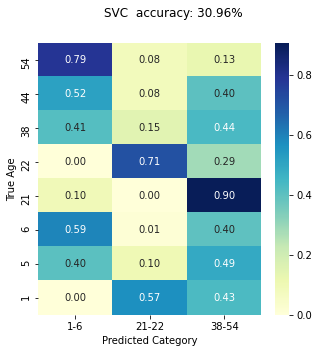

In [8]:
%%time
labels = tn["age"].values
age = np.unique(labels)
y = cat_labels
cm = pd.DataFrame(0, index=age, columns=np.unique(cat_labels))
genes = tn.columns
ypred = np.zeros(labels.shape, dtype=int)
print(cm.shape)

m = SVC(C=5, kernel='sigmoid', gamma='scale') # 30.96

for i,a in enumerate(age):
  samples = labels==a
  X_train, y_train =  tn.loc[~samples,"noise"], cat_labels[~samples]
  X_test, y_test = tn.loc[samples,"noise"], cat_labels[samples]
  m.fit(X_train.values.reshape(-1,1), y_train)
  pred = m.predict(X_test.values.reshape(-1,1))
  ypred[samples] = pred

  # update cm
  uni, count = np.unique(pred, return_counts=True)
  for yp,ycount in zip(uni,count):
    cm.loc[a,yp] = ycount/y_test.shape[0] 

cm = cm.sort_index(axis=0, ascending=False)

# compute accuracy
acc = round((accuracy_score(y_true=y, y_pred=ypred))*100, 2)
print("Accuracy:", acc)
recall = round((accuracy_score(y_true=y, y_pred=ypred))*100, 2)

# plot figure
nrow = 1
ncol = 1
s= 5
w = s*ncol
h = s*nrow
fig = plt.figure(figsize=(w,h))
ax = fig.add_subplot(nrow, ncol, 1)
sns.heatmap(cm, annot=True, fmt=".2f", cmap='YlGnBu')
plt.xlabel('Predicted Category')
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=["1-6", "21-22", "38-54"])
plt.ylabel('True Age')
fig.suptitle(f'SVC  accuracy: {acc}%')
plt.savefig(path['save']+'TN_cm_age_tissue.pdf', bbox_inches='tight', dpi=800)

## cell type wise prediction

In [10]:
%%time

age = np.unique(labels)
celltype_labels = vlm.ca['inferred_cell_type']
celltype = np.asarray(['acinar','alpha','beta','ductal'])
print("Unique age {}".format(age))

for ctype in celltype:
  print("="*30, "CELL TYPE {}".format(ctype), "="*30)
  csamples = celltype_labels == ctype
  X, y = tn.loc[csamples,"noise"], cat_labels[csamples]

  ypred = np.zeros(y.shape, dtype=int)
  cm = pd.DataFrame(0, index=age, columns=np.asarray([0,1,2]))

  # create classifier object
  m = SVC(kernel='sigmoid',C=30, degree=3, gamma='scale')

  for a in np.unique(age_labels[csamples]):
    samples = age_labels[csamples]==a
    # print("Age", a, samples.sum(), samples.shape)
    X_train, y_train = X[~samples], y[~samples]
    X_test, y_test = X[samples], y[samples]

    m.fit(X_train.values.reshape(-1,1), y_train)
    # print("training done")
    pred = m.predict(X_test.values.reshape(-1,1))
    # print("prediction done")

    ypred[samples] = pred
    
    # update cm
    uni, count = np.unique(pred, return_counts=True)
    # print(uni, count)
    for yp,ycount in zip(uni,count):
      cm.loc[a,yp] = ycount/y_test.shape[0] 

  cm = cm.sort_index(axis=0, ascending=False)
  
  # compute accuracy
  acc = round(accuracy_score(cat_labels[csamples], ypred)*100, 2)
  print("ACCURACY:", acc)

Unique age [ 1  5  6 21 22 38 44 54]
============================== CELL TYPE acinar ==============================
ACCURACY: 15.17
============================== CELL TYPE alpha ==============================
ACCURACY: 28.66
============================== CELL TYPE beta ==============================
ACCURACY: 9.5
============================== CELL TYPE ductal ==============================
ACCURACY: 15.57
CPU times: user 511 ms, sys: 118 µs, total: 511 ms
Wall time: 510 ms


# Accuracy Comparison between HDS and Transcriptional Noise

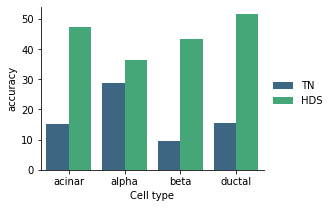

In [14]:
df = pd.DataFrame(columns=['accuracy', 'method', 'Cell type'])

newrow = {'method' : 'TN',
          'accuracy' : 15.17,
          'Cell type' : 'acinar'
          }
df = df.append(newrow, ignore_index=True)

newrow = {'method' : 'HDS',
          'accuracy' : 47.26,
          'Cell type' : 'acinar'
          }
df = df.append(newrow, ignore_index=True)

# alpha
newrow = {'method' : 'TN',
          'accuracy' : 28.66,
          'Cell type' : 'alpha'
          }
df = df.append(newrow, ignore_index=True)

newrow = {'method' : 'HDS',
          'accuracy' : 36.44,
          'Cell type' : 'alpha'
          }
df = df.append(newrow, ignore_index=True)

# beta
newrow = {'method' : 'TN',
          'accuracy' : 9.5,
          'Cell type' : 'beta'
          }
df = df.append(newrow, ignore_index=True)

newrow = {'method' : 'HDS',
          'accuracy' : 43.32,
          'Cell type' : 'beta'
          }
df = df.append(newrow, ignore_index=True)

# ductal
newrow = {'method' : 'TN',
          'accuracy' : 15.57,
          'Cell type' : 'ductal'
          }
df = df.append(newrow, ignore_index=True)

newrow = {'method' : 'HDS',
          'accuracy' : 51.45,
          'Cell type' : 'ductal'
          }
df = df.append(newrow, ignore_index=True)
df

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(1,1,1)
sns.barplot(y='accuracy', x='Cell type', data=df, hue='method', palette='viridis')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6), frameon=False)

plt.savefig(path['save']+f'accuracy_comparison_TN_HDS_celltypes.pdf', bbox_inches='tight', dpi=600)
